In [1]:
import os
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Define image transformations
transform = T.Compose([
    T.Resize(64),
    T.CenterCrop(64),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])  # Normalize images to [-1, 1]
])

# Download and load the dataset
dataset = CIFAR10(root='data/', download=True, transform=transform)

# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


100%|██████████| 170M/170M [00:02<00:00, 59.4MB/s] 


Extracting data/cifar-10-python.tar.gz to data/


In [3]:
class GeneratorACGAN(nn.Module):
    def __init__(self, num_classes=10):
        super(GeneratorACGAN, self).__init__()
        
        self.text_emb = nn.Sequential(
            nn.Linear(119, 256),
            nn.ReLU()
        )
        
        self.label_emb = nn.Embedding(num_classes, 50)
        
        self.fc = nn.Sequential(
            nn.Linear(100 + 256 + 50, 4 * 4 * 512)
        )
        
        self.net = nn.Sequential(
            nn.BatchNorm2d(512, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
        
    def forward(self, noise, text_input, labels):
        text_emb = self.text_emb(text_input)
        label_emb = self.label_emb(labels)
        x = torch.cat([noise, text_emb, label_emb], dim=1)
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)
        x = self.net(x)
        return x


In [4]:
class DiscriminatorACGAN(nn.Module):
    def __init__(self, num_classes=10):
        super(DiscriminatorACGAN, self).__init__()
        
        self.text_emb = nn.Sequential(
            nn.Linear(119, 256),
            nn.ReLU()
        )
        
        self.image_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.final_conv = nn.Conv2d(512 + 256, 512, kernel_size=1, stride=1)
        self.flatten = nn.Flatten()
        
        # Outputs
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )
        self.aux_layer = nn.Sequential(
            nn.Linear(512 * 4 * 4, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, image_input, text_input):
        text_emb = self.text_emb(text_input)
        text_emb = text_emb.view(-1, 256, 1, 1)
        text_emb = text_emb.repeat(1, 1, 4, 4)
        image_feat = self.image_net(image_input)
        combined = torch.cat([image_feat, text_emb], dim=1)
        x = self.final_conv(combined)
        x = self.flatten(x)
        validity = self.adv_layer(x)
        label = self.aux_layer(x)
        return validity, label


In [8]:
# Loss functions
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.NLLLoss()

# Create instances of the models
generator = GeneratorACGAN().to(device)
discriminator = DiscriminatorACGAN().to(device)

# Optimizers
lr = 0.0002
beta1 = 0.5
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))



In [9]:
def train_acgan(num_epochs):
    generator.train()
    discriminator.train()
    total_step = len(dataloader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(dataloader):
            batch_size_curr = images.size(0)
            images = images.to(device)
            labels = labels.to(device)
            
            # Adversarial ground truths
            valid = torch.ones(batch_size_curr, 1, device=device)
            fake = torch.zeros(batch_size_curr, 1, device=device)
            
            # Text embeddings (random for this example)
            text_inputs = torch.randn(batch_size_curr, 119, device=device)
            
            # =======================
            # Train Generator
            # =======================
            g_optimizer.zero_grad()
            
            # Sample noise and labels as generator input
            noise = torch.randn(batch_size_curr, 100, device=device)
            gen_labels = torch.randint(0, 10, (batch_size_curr,), device=device)
            
            # Generate images
            gen_images = generator(noise, text_inputs, gen_labels)
            
            # Loss measures generator's ability to fool the discriminator
            validity, pred_label = discriminator(gen_images, text_inputs)
            g_adv_loss = adversarial_loss(validity, valid)
            g_aux_loss = auxiliary_loss(pred_label, gen_labels)
            g_loss = g_adv_loss + g_aux_loss
            
            g_loss.backward()
            g_optimizer.step()
            
            # =======================
            # Train Discriminator
            # =======================
            d_optimizer.zero_grad()
            
            # Loss for real images
            real_pred, real_aux = discriminator(images, text_inputs)
            d_real_adv_loss = adversarial_loss(real_pred, valid)
            d_real_aux_loss = auxiliary_loss(real_aux, labels)
            d_real_loss = d_real_adv_loss + d_real_aux_loss
            
            # Loss for fake images
            fake_pred, fake_aux = discriminator(gen_images.detach(), text_inputs)
            d_fake_adv_loss = adversarial_loss(fake_pred, fake)
            d_fake_aux_loss = auxiliary_loss(fake_aux, gen_labels)
            d_fake_loss = d_fake_adv_loss + d_fake_aux_loss
            
            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            
            d_loss.backward()
            d_optimizer.step()
            
            # Print log info
            if (i+1) % 200 == 0:
                real_acc = (real_aux.argmax(dim=1) == labels).float().mean().item()
                fake_acc = (fake_aux.argmax(dim=1) == gen_labels).float().mean().item()
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], '
                      f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, '
                      f'D Real Acc: {real_acc:.4f}, D Fake Acc: {fake_acc:.4f}')
            
        # Save generated images at the end of each epoch
        save_fake_images(epoch+1)


In [10]:
def save_fake_images(epoch):
    generator.eval()
    with torch.no_grad():
        num_images = 64
        fixed_noise = torch.randn(num_images, 100, device=device)
        fixed_text = torch.randn(num_images, 119, device=device)
        labels = torch.randint(0, 10, (num_images,), device=device)
        fake_images = generator(fixed_noise, fixed_text, labels)
        fake_images = (fake_images + 1) / 2  # Rescale to [0,1]
        save_image(fake_images, f'fake_images_epoch_{epoch}.png', nrow=8)
    generator.train()


In [11]:
def generate_and_display_images(model, num_images=16):
    model.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100, device=device)
        text_inputs = torch.randn(num_images, 119, device=device)
        labels = torch.randint(0, 10, (num_images,), device=device)
        fake_images = model(noise, text_inputs, labels)
        fake_images = (fake_images + 1) / 2  # Rescale to [0,1]
        grid = make_grid(fake_images.cpu(), nrow=4)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.show()
    model.train()


In [12]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training Parameters
num_epochs = 50

# Start Training
train_acgan(num_epochs)


Epoch [1/50], Step [200/782], D Loss: 1.0417, G Loss: 1.5359, D Real Acc: 0.4688, D Fake Acc: 1.0000
Epoch [1/50], Step [400/782], D Loss: 1.2984, G Loss: 6.4162, D Real Acc: 0.4531, D Fake Acc: 1.0000
Epoch [1/50], Step [600/782], D Loss: 0.9558, G Loss: 1.1526, D Real Acc: 0.5781, D Fake Acc: 1.0000
Epoch [2/50], Step [200/782], D Loss: 0.9356, G Loss: 3.5426, D Real Acc: 0.4062, D Fake Acc: 1.0000
Epoch [2/50], Step [400/782], D Loss: 3.3333, G Loss: 11.6985, D Real Acc: 0.4375, D Fake Acc: 1.0000
Epoch [2/50], Step [600/782], D Loss: 0.6648, G Loss: 1.9643, D Real Acc: 0.6406, D Fake Acc: 1.0000
Epoch [3/50], Step [200/782], D Loss: 0.8218, G Loss: 2.8026, D Real Acc: 0.5469, D Fake Acc: 1.0000
Epoch [3/50], Step [400/782], D Loss: 1.0230, G Loss: 7.6702, D Real Acc: 0.6094, D Fake Acc: 1.0000
Epoch [3/50], Step [600/782], D Loss: 0.7667, G Loss: 2.2260, D Real Acc: 0.5781, D Fake Acc: 1.0000
Epoch [4/50], Step [200/782], D Loss: 0.7833, G Loss: 2.0411, D Real Acc: 0.6406, D Fake A

In [13]:
import re
import matplotlib.pyplot as plt


In [14]:
training_output = """
Epoch [1/50], Step [200/782], D Loss: 1.0417, G Loss: 1.5359, D Real Acc: 0.4688, D Fake Acc: 1.0000
Epoch [1/50], Step [400/782], D Loss: 1.2984, G Loss: 6.4162, D Real Acc: 0.4531, D Fake Acc: 1.0000
Epoch [1/50], Step [600/782], D Loss: 0.9558, G Loss: 1.1526, D Real Acc: 0.5781, D Fake Acc: 1.0000
Epoch [2/50], Step [200/782], D Loss: 0.9356, G Loss: 3.5426, D Real Acc: 0.4062, D Fake Acc: 1.0000
Epoch [2/50], Step [400/782], D Loss: 3.3333, G Loss: 11.6985, D Real Acc: 0.4375, D Fake Acc: 1.0000
Epoch [2/50], Step [600/782], D Loss: 0.6648, G Loss: 1.9643, D Real Acc: 0.6406, D Fake Acc: 1.0000
Epoch [3/50], Step [200/782], D Loss: 0.8218, G Loss: 2.8026, D Real Acc: 0.5469, D Fake Acc: 1.0000
Epoch [3/50], Step [400/782], D Loss: 1.0230, G Loss: 7.6702, D Real Acc: 0.6094, D Fake Acc: 1.0000
Epoch [3/50], Step [600/782], D Loss: 0.7667, G Loss: 2.2260, D Real Acc: 0.5781, D Fake Acc: 1.0000
Epoch [4/50], Step [200/782], D Loss: 0.7833, G Loss: 2.0411, D Real Acc: 0.6406, D Fake Acc: 1.0000
Epoch [4/50], Step [400/782], D Loss: 0.6124, G Loss: 5.8078, D Real Acc: 0.6250, D Fake Acc: 1.0000
Epoch [4/50], Step [600/782], D Loss: 0.4800, G Loss: 4.4075, D Real Acc: 0.6250, D Fake Acc: 1.0000
Epoch [5/50], Step [200/782], D Loss: 0.5203, G Loss: 3.2659, D Real Acc: 0.7500, D Fake Acc: 1.0000
Epoch [5/50], Step [400/782], D Loss: 0.5622, G Loss: 3.8805, D Real Acc: 0.6875, D Fake Acc: 1.0000
Epoch [5/50], Step [600/782], D Loss: 0.6490, G Loss: 2.1548, D Real Acc: 0.6562, D Fake Acc: 1.0000
Epoch [6/50], Step [200/782], D Loss: 0.5924, G Loss: 7.1805, D Real Acc: 0.6875, D Fake Acc: 1.0000
Epoch [6/50], Step [400/782], D Loss: 0.4606, G Loss: 1.8730, D Real Acc: 0.7812, D Fake Acc: 1.0000
Epoch [6/50], Step [600/782], D Loss: 0.5241, G Loss: 8.7924, D Real Acc: 0.6719, D Fake Acc: 1.0000
Epoch [7/50], Step [200/782], D Loss: 0.5132, G Loss: 5.7095, D Real Acc: 0.6406, D Fake Acc: 1.0000
Epoch [7/50], Step [400/782], D Loss: 0.3424, G Loss: 9.0424, D Real Acc: 0.7969, D Fake Acc: 1.0000
Epoch [7/50], Step [600/782], D Loss: 0.4361, G Loss: 6.5031, D Real Acc: 0.7812, D Fake Acc: 1.0000
Epoch [8/50], Step [200/782], D Loss: 0.4356, G Loss: 4.1534, D Real Acc: 0.7031, D Fake Acc: 1.0000
Epoch [8/50], Step [400/782], D Loss: 0.5361, G Loss: 8.5326, D Real Acc: 0.6250, D Fake Acc: 1.0000
Epoch [8/50], Step [600/782], D Loss: 0.4358, G Loss: 3.8716, D Real Acc: 0.7344, D Fake Acc: 1.0000
Epoch [9/50], Step [200/782], D Loss: 0.5521, G Loss: 2.1127, D Real Acc: 0.8125, D Fake Acc: 1.0000
Epoch [9/50], Step [400/782], D Loss: 0.2483, G Loss: 4.4908, D Real Acc: 0.8438, D Fake Acc: 1.0000
Epoch [9/50], Step [600/782], D Loss: 0.3087, G Loss: 7.8953, D Real Acc: 0.7500, D Fake Acc: 1.0000
Epoch [10/50], Step [200/782], D Loss: 3.4437, G Loss: 21.0557, D Real Acc: 0.6875, D Fake Acc: 1.0000
Epoch [10/50], Step [400/782], D Loss: 0.2802, G Loss: 3.3093, D Real Acc: 0.7969, D Fake Acc: 1.0000
Epoch [10/50], Step [600/782], D Loss: 0.2984, G Loss: 6.5193, D Real Acc: 0.7812, D Fake Acc: 1.0000
Epoch [11/50], Step [200/782], D Loss: 0.4304, G Loss: 8.4744, D Real Acc: 0.7969, D Fake Acc: 1.0000
Epoch [11/50], Step [400/782], D Loss: 0.3874, G Loss: 4.6570, D Real Acc: 0.7344, D Fake Acc: 0.9688
Epoch [11/50], Step [600/782], D Loss: 0.3920, G Loss: 16.9717, D Real Acc: 0.7500, D Fake Acc: 1.0000
Epoch [12/50], Step [200/782], D Loss: 0.1991, G Loss: 12.3110, D Real Acc: 0.8594, D Fake Acc: 1.0000
Epoch [12/50], Step [400/782], D Loss: 0.2391, G Loss: 6.5726, D Real Acc: 0.8281, D Fake Acc: 1.0000
Epoch [12/50], Step [600/782], D Loss: 1.8204, G Loss: 16.1307, D Real Acc: 0.7812, D Fake Acc: 1.0000
Epoch [13/50], Step [200/782], D Loss: 1.9893, G Loss: 0.6774, D Real Acc: 0.6562, D Fake Acc: 0.9844
Epoch [13/50], Step [400/782], D Loss: 0.3731, G Loss: 16.0619, D Real Acc: 0.8906, D Fake Acc: 1.0000
Epoch [13/50], Step [600/782], D Loss: 0.3731, G Loss: 3.7220, D Real Acc: 0.8281, D Fake Acc: 1.0000
Epoch [14/50], Step [200/782], D Loss: 0.1744, G Loss: 7.7832, D Real Acc: 0.8594, D Fake Acc: 1.0000
Epoch [14/50], Step [400/782], D Loss: 0.1690, G Loss: 6.1494, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [14/50], Step [600/782], D Loss: 0.1754, G Loss: 10.9171, D Real Acc: 0.9062, D Fake Acc: 1.0000
Epoch [15/50], Step [200/782], D Loss: 0.1922, G Loss: 9.0695, D Real Acc: 0.8750, D Fake Acc: 1.0000
Epoch [15/50], Step [400/782], D Loss: 0.2891, G Loss: 8.7869, D Real Acc: 0.7969, D Fake Acc: 1.0000
Epoch [15/50], Step [600/782], D Loss: 0.1254, G Loss: 10.0495, D Real Acc: 0.9219, D Fake Acc: 1.0000
Epoch [16/50], Step [200/782], D Loss: 0.3057, G Loss: 7.3391, D Real Acc: 0.8750, D Fake Acc: 1.0000
Epoch [16/50], Step [400/782], D Loss: 0.2036, G Loss: 7.9820, D Real Acc: 0.9219, D Fake Acc: 1.0000
Epoch [16/50], Step [600/782], D Loss: 0.1599, G Loss: 8.1676, D Real Acc: 0.8906, D Fake Acc: 1.0000
Epoch [17/50], Step [200/782], D Loss: 1.3569, G Loss: 15.9781, D Real Acc: 0.8906, D Fake Acc: 1.0000
Epoch [17/50], Step [400/782], D Loss: 0.2379, G Loss: 4.2049, D Real Acc: 0.8750, D Fake Acc: 1.0000
Epoch [17/50], Step [600/782], D Loss: 0.2418, G Loss: 8.3305, D Real Acc: 0.9062, D Fake Acc: 1.0000
Epoch [18/50], Step [200/782], D Loss: 0.2461, G Loss: 5.1921, D Real Acc: 0.8438, D Fake Acc: 1.0000
Epoch [18/50], Step [400/782], D Loss: 0.1031, G Loss: 9.1171, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [18/50], Step [600/782], D Loss: 0.2062, G Loss: 4.2930, D Real Acc: 0.8750, D Fake Acc: 1.0000
Epoch [19/50], Step [200/782], D Loss: 0.0972, G Loss: 5.9104, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [19/50], Step [400/782], D Loss: 0.3520, G Loss: 3.9343, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [19/50], Step [600/782], D Loss: 0.1594, G Loss: 7.5868, D Real Acc: 0.8594, D Fake Acc: 1.0000
Epoch [20/50], Step [200/782], D Loss: 0.2190, G Loss: 6.5416, D Real Acc: 0.9062, D Fake Acc: 1.0000
Epoch [20/50], Step [400/782], D Loss: 0.0764, G Loss: 8.6717, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [20/50], Step [600/782], D Loss: 0.1481, G Loss: 4.0488, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [21/50], Step [200/782], D Loss: 0.3717, G Loss: 3.5078, D Real Acc: 0.9219, D Fake Acc: 1.0000
Epoch [21/50], Step [400/782], D Loss: 0.1010, G Loss: 3.7923, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [21/50], Step [600/782], D Loss: 0.1306, G Loss: 10.7153, D Real Acc: 0.8750, D Fake Acc: 1.0000
Epoch [22/50], Step [200/782], D Loss: 0.1587, G Loss: 6.2358, D Real Acc: 0.8906, D Fake Acc: 1.0000
Epoch [22/50], Step [400/782], D Loss: 0.1190, G Loss: 4.3998, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [22/50], Step [600/782], D Loss: 0.1830, G Loss: 6.6332, D Real Acc: 0.8906, D Fake Acc: 1.0000
Epoch [23/50], Step [200/782], D Loss: 0.1565, G Loss: 2.1312, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [23/50], Step [400/782], D Loss: 0.0921, G Loss: 11.5071, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [23/50], Step [600/782], D Loss: 0.1744, G Loss: 7.0589, D Real Acc: 0.8906, D Fake Acc: 1.0000
Epoch [24/50], Step [200/782], D Loss: 0.0460, G Loss: 8.6568, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [24/50], Step [400/782], D Loss: 0.1419, G Loss: 5.9422, D Real Acc: 0.9219, D Fake Acc: 1.0000
Epoch [24/50], Step [600/782], D Loss: 0.0775, G Loss: 4.2991, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [25/50], Step [200/782], D Loss: 0.1332, G Loss: 3.0872, D Real Acc: 1.0000, D Fake Acc: 1.0000
Epoch [25/50], Step [400/782], D Loss: 0.1044, G Loss: 5.0675, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [25/50], Step [600/782], D Loss: 0.0614, G Loss: 5.2712, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [26/50], Step [200/782], D Loss: 0.0988, G Loss: 9.3924, D Real Acc: 0.9062, D Fake Acc: 1.0000
Epoch [26/50], Step [400/782], D Loss: 0.1379, G Loss: 10.6301, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [26/50], Step [600/782], D Loss: 0.9421, G Loss: 18.6746, D Real Acc: 0.9219, D Fake Acc: 1.0000
Epoch [27/50], Step [200/782], D Loss: 0.1602, G Loss: 6.0300, D Real Acc: 0.8906, D Fake Acc: 1.0000
Epoch [27/50], Step [400/782], D Loss: 0.0794, G Loss: 4.9751, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [27/50], Step [600/782], D Loss: 0.0813, G Loss: 9.8638, D Real Acc: 0.9062, D Fake Acc: 1.0000
Epoch [28/50], Step [200/782], D Loss: 0.0401, G Loss: 10.5330, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [28/50], Step [400/782], D Loss: 0.1544, G Loss: 16.2043, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [28/50], Step [600/782], D Loss: 0.0774, G Loss: 7.9766, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [29/50], Step [200/782], D Loss: 0.0961, G Loss: 8.8818, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [29/50], Step [400/782], D Loss: 0.0876, G Loss: 3.0177, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [29/50], Step [600/782], D Loss: 0.0978, G Loss: 8.4375, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [30/50], Step [200/782], D Loss: 0.0394, G Loss: 6.7305, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [30/50], Step [400/782], D Loss: 0.0938, G Loss: 12.5426, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [30/50], Step [600/782], D Loss: 0.0772, G Loss: 5.1894, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [31/50], Step [200/782], D Loss: 0.0773, G Loss: 8.4085, D Real Acc: 0.9219, D Fake Acc: 1.0000
Epoch [31/50], Step [400/782], D Loss: 0.1395, G Loss: 2.5690, D Real Acc: 0.9219, D Fake Acc: 1.0000
Epoch [31/50], Step [600/782], D Loss: 0.0597, G Loss: 8.5921, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [32/50], Step [200/782], D Loss: 0.1981, G Loss: 7.2865, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [32/50], Step [400/782], D Loss: 0.0133, G Loss: 9.0101, D Real Acc: 1.0000, D Fake Acc: 1.0000
Epoch [32/50], Step [600/782], D Loss: 0.0398, G Loss: 13.5991, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [33/50], Step [200/782], D Loss: 0.2825, G Loss: 17.9046, D Real Acc: 0.9062, D Fake Acc: 1.0000
Epoch [33/50], Step [400/782], D Loss: 0.1668, G Loss: 7.8291, D Real Acc: 0.9219, D Fake Acc: 1.0000
Epoch [33/50], Step [600/782], D Loss: 0.0232, G Loss: 7.4997, D Real Acc: 1.0000, D Fake Acc: 1.0000
Epoch [34/50], Step [200/782], D Loss: 0.0739, G Loss: 9.0720, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [34/50], Step [400/782], D Loss: 0.0916, G Loss: 7.7630, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [34/50], Step [600/782], D Loss: 0.0628, G Loss: 6.5961, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [35/50], Step [200/782], D Loss: 0.1240, G Loss: 27.0964, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [35/50], Step [400/782], D Loss: 0.0871, G Loss: 5.6963, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [35/50], Step [600/782], D Loss: 0.0498, G Loss: 9.5874, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [36/50], Step [200/782], D Loss: 0.0246, G Loss: 14.6060, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [36/50], Step [400/782], D Loss: 0.0922, G Loss: 7.6742, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [36/50], Step [600/782], D Loss: 0.1457, G Loss: 5.6277, D Real Acc: 0.9219, D Fake Acc: 1.0000
Epoch [37/50], Step [200/782], D Loss: 0.0373, G Loss: 8.6622, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [37/50], Step [400/782], D Loss: 0.0740, G Loss: 10.6228, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [37/50], Step [600/782], D Loss: 0.0492, G Loss: 11.7725, D Real Acc: 1.0000, D Fake Acc: 1.0000
Epoch [38/50], Step [200/782], D Loss: 0.1185, G Loss: 8.5680, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [38/50], Step [400/782], D Loss: 0.0962, G Loss: 5.6233, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [38/50], Step [600/782], D Loss: 0.0534, G Loss: 10.6942, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [39/50], Step [200/782], D Loss: 0.1059, G Loss: 18.0481, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [39/50], Step [400/782], D Loss: 0.0459, G Loss: 4.0711, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [39/50], Step [600/782], D Loss: 0.1312, G Loss: 4.9220, D Real Acc: 0.9531, D Fake Acc: 0.9844
Epoch [40/50], Step [200/782], D Loss: 0.0361, G Loss: 10.3227, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [40/50], Step [400/782], D Loss: 0.0126, G Loss: 9.6039, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [40/50], Step [600/782], D Loss: 0.0442, G Loss: 5.9449, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [41/50], Step [200/782], D Loss: 0.0932, G Loss: 22.0733, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [41/50], Step [400/782], D Loss: 0.0566, G Loss: 3.5625, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [41/50], Step [600/782], D Loss: 0.0347, G Loss: 6.1627, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [42/50], Step [200/782], D Loss: 0.0728, G Loss: 9.9960, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [42/50], Step [400/782], D Loss: 0.0860, G Loss: 23.4814, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [42/50], Step [600/782], D Loss: 0.0473, G Loss: 9.9899, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [43/50], Step [200/782], D Loss: 0.1247, G Loss: 8.8192, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [43/50], Step [400/782], D Loss: 0.0336, G Loss: 6.4553, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [43/50], Step [600/782], D Loss: 0.0735, G Loss: 3.9467, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [44/50], Step [200/782], D Loss: 0.2145, G Loss: 5.6932, D Real Acc: 0.9062, D Fake Acc: 1.0000
Epoch [44/50], Step [400/782], D Loss: 0.0202, G Loss: 11.6479, D Real Acc: 1.0000, D Fake Acc: 1.0000
Epoch [44/50], Step [600/782], D Loss: 0.0349, G Loss: 4.4324, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [45/50], Step [200/782], D Loss: 0.0555, G Loss: 13.3069, D Real Acc: 0.9375, D Fake Acc: 1.0000
Epoch [45/50], Step [400/782], D Loss: 0.1112, G Loss: 16.1369, D Real Acc: 0.9219, D Fake Acc: 0.9844
Epoch [45/50], Step [600/782], D Loss: 0.1896, G Loss: 5.1285, D Real Acc: 0.9062, D Fake Acc: 1.0000
Epoch [46/50], Step [200/782], D Loss: 0.0560, G Loss: 14.5161, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [46/50], Step [400/782], D Loss: 0.0366, G Loss: 12.1436, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [46/50], Step [600/782], D Loss: 0.2963, G Loss: 17.8929, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [47/50], Step [200/782], D Loss: 0.0404, G Loss: 9.7703, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [47/50], Step [400/782], D Loss: 0.1045, G Loss: 9.8914, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [47/50], Step [600/782], D Loss: 0.0542, G Loss: 13.2860, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [48/50], Step [200/782], D Loss: 0.0528, G Loss: 10.5473, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [48/50], Step [400/782], D Loss: 0.0324, G Loss: 12.1477, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [48/50], Step [600/782], D Loss: 0.0668, G Loss: 12.4883, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [49/50], Step [200/782], D Loss: 0.0586, G Loss: 7.6255, D Real Acc: 0.9531, D Fake Acc: 1.0000
Epoch [49/50], Step [400/782], D Loss: 0.0558, G Loss: 12.7625, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [49/50], Step [600/782], D Loss: 0.0488, G Loss: 9.0048, D Real Acc: 0.9844, D Fake Acc: 1.0000
Epoch [50/50], Step [200/782], D Loss: 0.1721, G Loss: 2.0638, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [50/50], Step [400/782], D Loss: 0.0367, G Loss: 4.6860, D Real Acc: 0.9688, D Fake Acc: 1.0000
Epoch [50/50], Step [600/782], D Loss: 0.0177, G Loss: 4.6783, D Real Acc: 1.0000, D Fake Acc: 1.0000
"""


In [15]:
losses_d = []
losses_g = []
real_accs = []
fake_accs = []


In [16]:
lines = training_output.strip().split('\n')


In [17]:
for line in lines:
    # Use regular expressions to extract the values
    match = re.search(
        r'Epoch \[(\d+)/(\d+)\], Step \[(\d+)/(\d+)\], '
        r'D Loss: ([0-9\.]+), G Loss: ([0-9\.]+), '
        r'D Real Acc: ([0-9\.]+), D Fake Acc: ([0-9\.]+)',
        line)
    if match:
        # Extract the values
        epoch = int(match.group(1))
        total_epochs = int(match.group(2))
        step = int(match.group(3))
        total_steps = int(match.group(4))
        d_loss = float(match.group(5))
        g_loss = float(match.group(6))
        d_real_acc = float(match.group(7))
        d_fake_acc = float(match.group(8))

        # Append the losses and accuracies to the lists
        losses_d.append(d_loss)
        losses_g.append(g_loss)
        real_accs.append(d_real_acc)
        fake_accs.append(d_fake_acc)


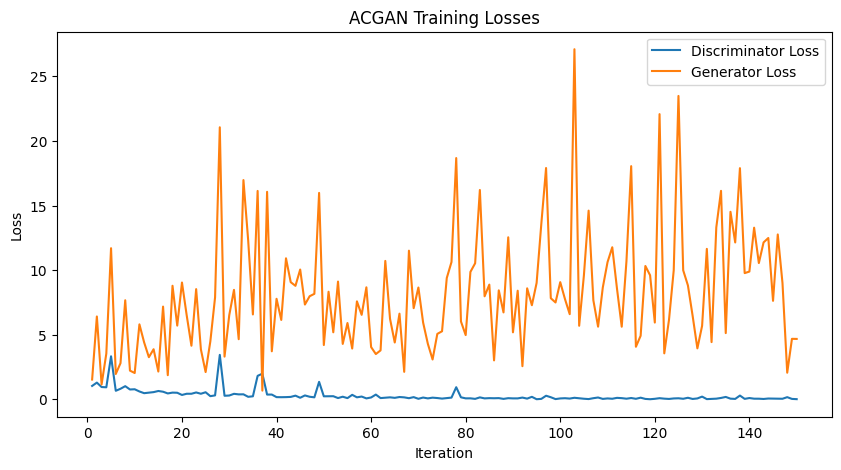

In [19]:
import matplotlib.pyplot as plt

# Create a list of iterations
iterations = list(range(1, len(losses_d) + 1))

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(iterations, losses_d, label='Discriminator Loss')
plt.plot(iterations, losses_g, label='Generator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('ACGAN Training Losses')
plt.legend()
plt.show()


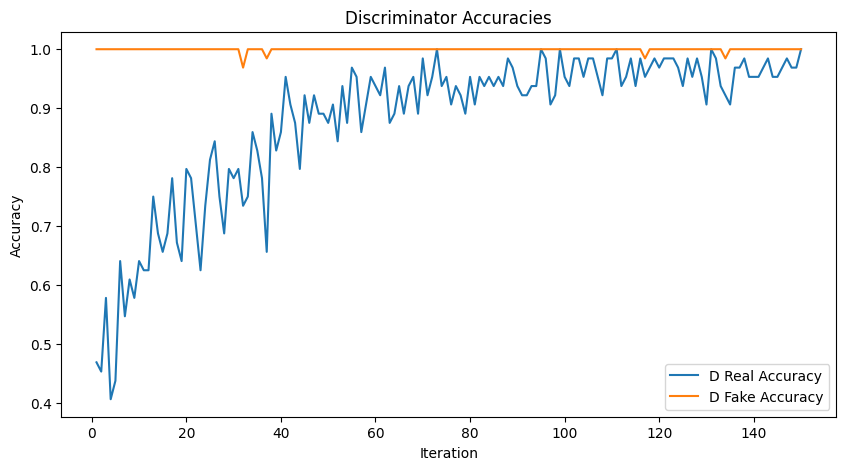

In [20]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(iterations, real_accs, label='D Real Accuracy')
plt.plot(iterations, fake_accs, label='D Fake Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracies')
plt.legend()
plt.show()
